In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime
import gdown
from tensorflow.keras import models, layers, metrics
from transformers import BertTokenizerFast, DistilBertConfig, TFDistilBertModel
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import imblearn
from tqdm import tqdm
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [2]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/NLP/Handin/Data/df_reviews_final_binary.csv', usecols=['review_comments', 'review_rating'])
data['review_comments'] = data['review_comments'].astype(str)
data['review_rating'] = data['review_rating'].astype(str)
data['review_rating'] = data['review_rating'].apply(lambda x: 1 if x == 'positive' else 0)
num_classes = len(data['review_rating'].unique())
X = data['review_comments']
y = np.unique(data['review_rating'], return_inverse=True)[1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [22]:
tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased')
X_train = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in tqdm(X_train)]
X_train = np.array(X_train, dtype='int32')
X_test = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in tqdm(X_test)]
X_test = np.array(X_test, dtype='int32')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
100%|██████████| 47807/47807 [00:20<00:00, 2369.44it/s]


In [23]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)
input_ids_in = layers.Input(shape=(512,), dtype='int32')
x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
feature_extractor = models.Model(inputs=input_ids_in, outputs=x)
feature_extractor.compile()
X_train_features = feature_extractor.predict(X_train, verbose=1, batch_size=16, use_multiprocessing=True)
X_test_features = feature_extractor.predict(X_test, verbose=1, batch_size=16, use_multiprocessing=True)
print(X_train.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


2988/2988 [==============================] - 457s 153ms/step
(191224, 512)


In [24]:
np.save('X_train.npy', X_train_features)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test_features)
np.save('y_test.npy', y_test)

In [25]:
X_train_features = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test_features = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [26]:
y_train.sum()

190070

In [27]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 191224
    Positive: 190070 (99.40% of total)



In [28]:
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_features, y_train = oversample.fit_resample(X_train_features, y_train)

In [29]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 380140
    Positive: 190070 (50.00% of total)



In [30]:
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_train_features, y_train, test_size=0.25, random_state=42)

In [31]:
input = layers.Input(shape=(768,), dtype='float32')
x = layers.Dense(256, activation='tanh', kernel_initializer= 'he_normal')(input)
x = layers.Dense(128, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dense(32, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dropout(0.1)(x)
out = layers.Dense(2, activation='softmax', dtype = 'float32')(x)
model = models.Model(inputs=input, outputs = out)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])

In [32]:
callbacks = [ModelCheckpoint('final_model_tanh.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
            EarlyStopping(monitor='val_loss', patience=64, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=16, verbose=1, min_lr=1e-8),
            tensorboard_callback]

In [33]:
history = model.fit(X_tf_train, y_tf_train, batch_size=512, shuffle=True, epochs=512, validation_data=(X_tf_test, y_tf_test),
                       callbacks = callbacks)

Epoch 1/512


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f909197fd90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7f909197fd90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
557/557 [==============================] - ETA: 0s - loss: 0.2967 - sparse_categorical_accuracy: 0.8705
Epoch 1: val_loss improved from inf to 0.17662, saving model to final_model_tanh.hdf5
557/557 [==============================] - 23s 13ms/step - loss: 0.2967 - sparse_categorical_accuracy: 0.8705 - val_loss: 0.1766 - val_sparse_categorical_accuracy: 0.9364 - lr: 0.0010
Epoch 2/512
551/557 [============================>.] - ETA: 0s - loss: 0.1854 - sparse_categorical_accuracy: 0.9299
Epoch 2: val_loss improved from 0.17662 to 0.15566, saving model to final_model_tanh.hdf5
557/557 [==============================] - 4s 7ms/step - loss: 0.1849 - sparse_categorical_accuracy: 0.9301 - val_los

Text(0.5, 1.02, 'Training Metrics for Random Oversamplling')

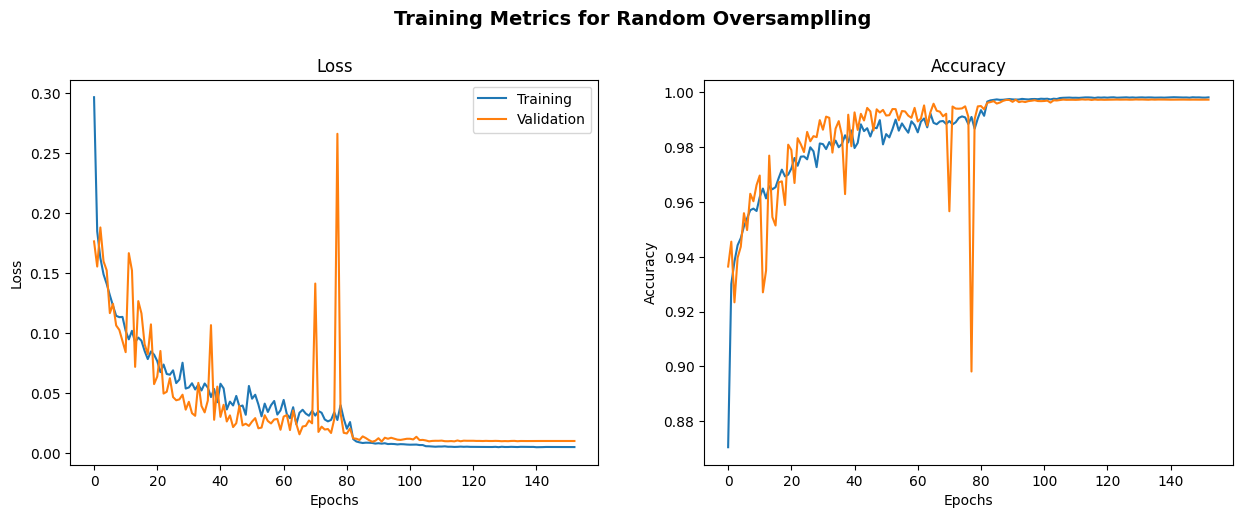

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set(title='Accuracy')
ax[1].plot(history.history['sparse_categorical_accuracy'], label='Training')
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
fig.suptitle('Training Metrics for Random Oversamplling', fontsize=14, fontweight='bold', y=1.02)

In [35]:
y_pred = model.predict(X_test_features, verbose = 1, use_multiprocessing = True)

1494/1494 [==============================] - 3s 2ms/step


In [36]:
y_pred_max = np.argmax(y_pred, axis=1)
report = classification_report(y_pred_max, y_test, output_dict=True)
report = pd.DataFrame(report).T
print(report)
report.to_csv('final_model_tanh.csv', index = False)

              precision    recall  f1-score       support
0              0.628472  0.393478  0.483957    460.000000
1              0.994129  0.997740  0.995931  47347.000000
accuracy       0.991926  0.991926  0.991926      0.991926
macro avg      0.811300  0.695609  0.739944  47807.000000
weighted avg   0.990610  0.991926  0.991005  47807.000000


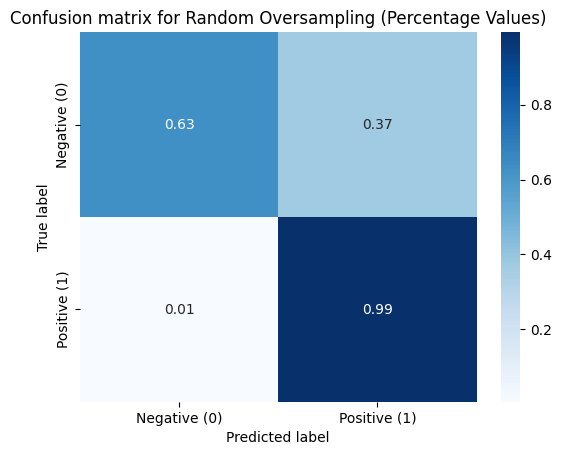

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_max)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['Negative (0)', 'Positive (1)']
plt.xticks(np.arange(2) + 0.5, labels)
plt.yticks(np.arange(2) + 0.5, labels)
plt.title('Confusion matrix for Random Oversampling (Percentage Values)')
plt.show()

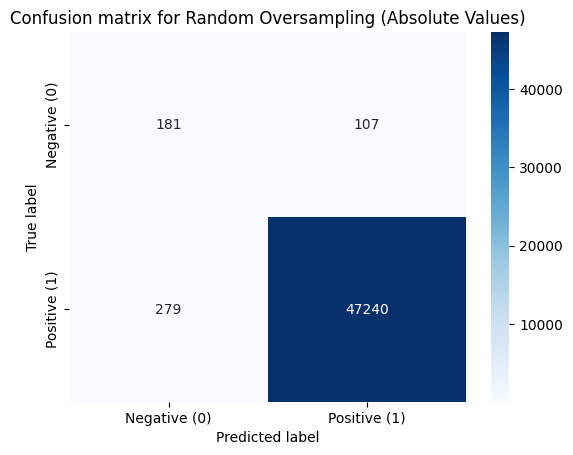

In [38]:
cm = confusion_matrix(y_test, y_pred_max)
sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['Negative (0)', 'Positive (1)']
plt.xticks(np.arange(2) + 0.5, labels)
plt.yticks(np.arange(2) + 0.5, labels)
plt.title('Confusion matrix for Random Oversampling (Absolute Values)')
plt.show()